In [98]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [100]:
import numpy as np
import matplotlib.dates as mdates

In [101]:
df = pd.read_json("newsdata.json", lines=True)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [103]:
df['text'] = (
    df['headline'].fillna('') + ". " +
    df['short_description'].fillna('')
).str.strip()

In [104]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['time_bin'] = df['date'].dt.to_period('M').dt.to_timestamp()

df.head()

,link,headline,category,short_description,authors,date,text,time_bin
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-01
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",2022-09-01
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-01
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,2022-09-01
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-01


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
 6   text               209527 non-null  object        
 7   time_bin           209527 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(6)
memory usage: 12.8+ MB


In [106]:
df = df[df['text'].str.len() > 10].reset_index(drop=True) # filtering short texts in the dataset

In [ ]:
df = df.head(25000)


In [108]:
df

,link,headline,category,short_description,authors,date,text,time_bin
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-01
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",2022-09-01
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-01
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,2022-09-01
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-01
...,...,...,...,...,...,...,...,...
4995,https://www.huffpost.com/entry/anthony-causi-d...,"Anthony Causi, Popular Sports Photographer, De...",SPORTS,The New York Post photographer covered the cit...,"Mike Fitzpatrick, AP",2020-04-13,"Anthony Causi, Popular Sports Photographer, De...",2020-04-01
4996,https://www.huffpost.com/entry/olive-veronesi-...,93-Year-Old Woman Goes Viral When She Tells In...,WEIRD NEWS,"On Monday, Coors Light dropped off 150 cans of...",David Moye,2020-04-13,93-Year-Old Woman Goes Viral When She Tells In...,2020-04-01
4997,https://www.huffpost.com/entry/donald-trump-fi...,Trump Retweets 'Fire Fauci' Coronavirus Messag...,POLITICS,The retweet came hours after Fauci suggested e...,Ed Mazza,2020-04-13,Trump Retweets 'Fire Fauci' Coronavirus Messag...,2020-04-01
4998,https://www.huffpost.com/entry/war-pandemic-co...,A Pandemic Is Not A War,POLITICS,Relying on tired metaphors to understand an un...,"By Eve Fairbanks, On Assignment For HuffPost",2020-04-13,A Pandemic Is Not A War. Relying on tired meta...,2020-04-01


In [109]:
# Cell 3: load saved BERTopic model and embeddings (assumes files exist)
import os
import json
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import numpy as np

texts = df['text'].tolist()

saved_dir = "saved_trains"
model_path = os.path.join(saved_dir, "bertopic_model")
emb_path = os.path.join(saved_dir, "embeddings.npy")
meta_path = os.path.join(saved_dir, "metadata.json")

# Load fitted BERTopic model and saved embeddings
topic_model = BERTopic.load(model_path)
embeddings = np.load(emb_path).astype(np.float32)

# Optional: read metadata to know which encoder was used
embedding_model_name = None
if os.path.exists(meta_path):
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)
        embedding_model_name = meta.get("embedding_model")

# Option A — explicit keywords (recommended)
new_topics, new_probs = topic_model.transform(documents=texts, embeddings=embeddings)

# Option B — positional documents + keyword embeddings
# new_topics, new_probs = topic_model.transform(texts, embeddings=embeddings)

# Attach results to dataframe
df['topic'] = new_topics
df['topic_prob'] = new_probs

print("Loaded saved model and embeddings; assigned topics to documents.")


Loaded saved model and embeddings; assigned topics to documents.


In [110]:
#df['topic'] = topics
#df['topic_prob'] = probs

In [111]:
topic_info = topic_model.get_topic_info()
valid_topics = topic_info[topic_info["Topic"] >= 0]["Topic"].tolist() #removing outlier topic

In [112]:
topic_names = {}

for t in valid_topics:
    words = topic_model.get_topic(t)
    topic_names[t] = ", ".join([w[0] for w in words[:4]])  # top 5 words



In [113]:
df["topic_name"] = df["topic"].map(topic_names)

df = df[df["topic"] != -1].reset_index(drop=True) #removing


In [114]:
# Compute topic frequency (topic prevalence)
topics_over_time = (
    df.groupby(['time_bin', 'topic'])
      .size()
      .reset_index(name='Frequency')
)


In [115]:


# Pivot table
pivot = topics_over_time.pivot_table(
    index='time_bin',
    columns='topic',
    values='Frequency',
    fill_value=0
).sort_index()




In [116]:
# Remove topic -1 column if present
pivot = pivot.drop(columns=[-1], errors='ignore')

# Normalize to probabilities
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)






In [117]:
rw = 3

# rolling mean (trailing). Use center=True if you prefer centered window.
rolling_mean = pivot_norm.rolling(window=rw, min_periods=1, center=False).mean()

# use ddof=0 to avoid NaNs for single-value windows; then clip tiny stds to a floor
rolling_std = pivot_norm.rolling(window=rw, min_periods=1, center=False).std(ddof=0)

# set a small floor to avoid huge z-scores from tiny std
std_floor = 1e-6
rolling_std = rolling_std.clip(lower=std_floor)

zscore = (pivot_norm - rolling_mean) / rolling_std
zscore = zscore.replace([np.inf, -np.inf], np.nan).fillna(0)


In [118]:
#zscore = (pivot_norm - rolling_mean) / rolling_std
#zscore = zscore.fillna(0)

In [119]:

topk = 6
# Select top-K topics (by total prevalence)
top_k_ids = pivot_norm.sum().sort_values(ascending=False).head(topk).index.tolist()

top_topics = [topic_names[t] for t in top_k_ids]



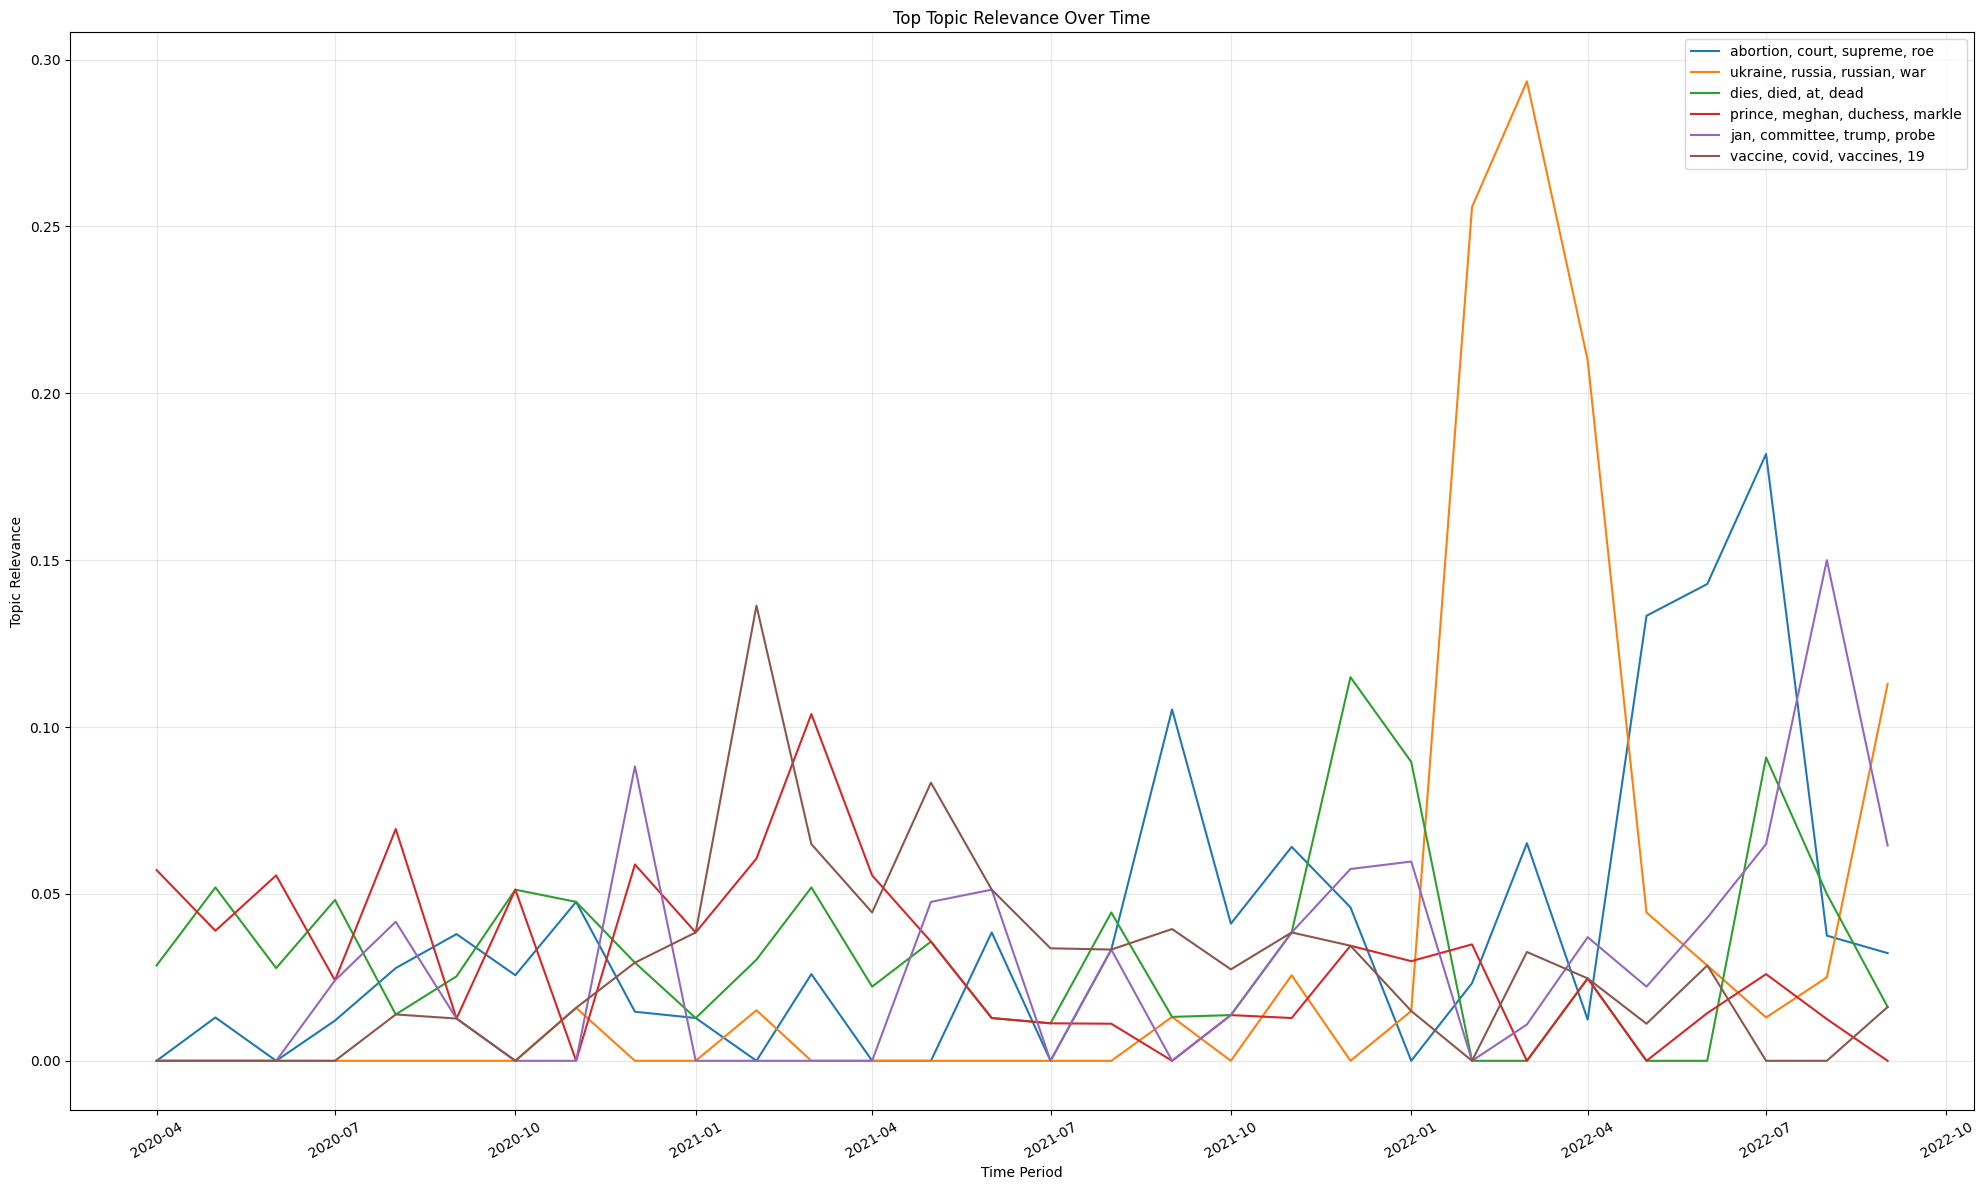

In [120]:
plt.figure(figsize=(20,12))

for t in top_k_ids:
    label = topic_names[t]   
    plt.plot(pivot_norm.index, pivot_norm[t], label=label)

plt.xlabel("Time Period")
plt.ylabel("Topic Relevance")
plt.title("Top Topic Relevance Over Time")
plt.xticks(rotation=30)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


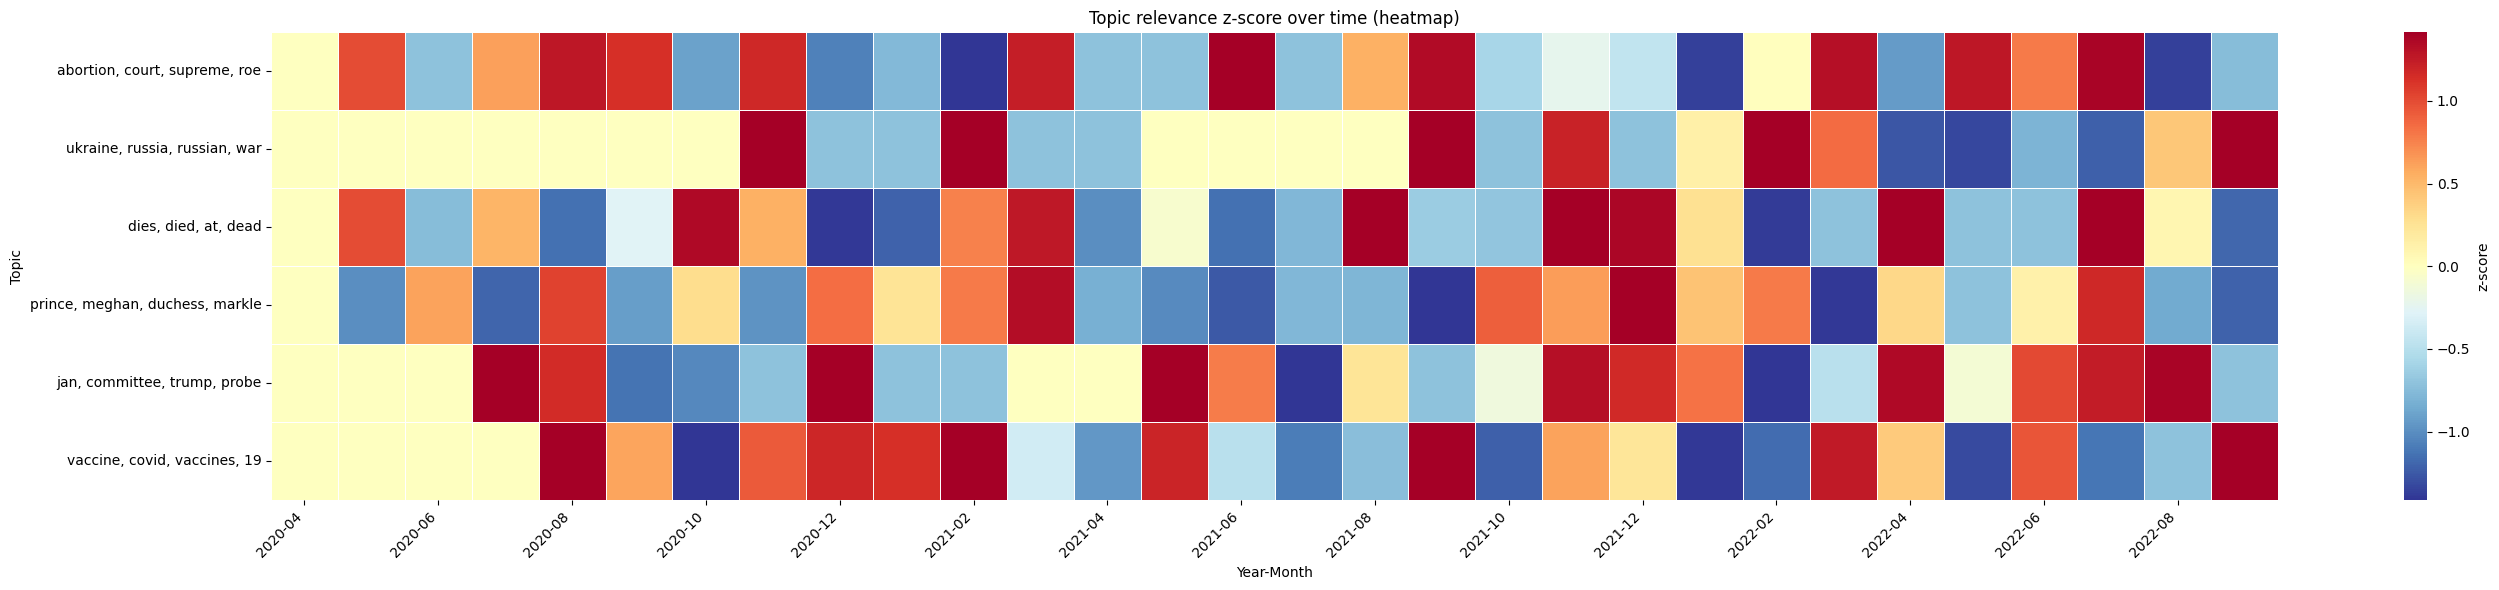

In [121]:
# Cell: heatmap of z-scores for selected topics (top_k_ids -> readable names)


# Ensure topics exist in zscore
heat_ids = [t for t in top_k_ids if t in zscore.columns]
if not heat_ids:
    raise ValueError("None of the top_k_ids are present in the zscore DataFrame.")

# Build a DataFrame for the heatmap: rows = topics (readable names), cols = time bins
heat_df = zscore[heat_ids].T.copy()
heat_df.index = [topic_names[t] for t in heat_df.index]  # readable labels

plt.figure(figsize=(28, 6))
ax = sns.heatmap(heat_df, cmap='RdYlBu_r', center=0, cbar_kws={'label': 'z-score'}, linewidths=0.5, linecolor='white')

# Build Year-Month labels from the time index
time_bins = zscore.index.to_list()
labels = [d.strftime('%Y-%m') for d in time_bins]

# Reduce tick density (show at most ~12 ticks)
n_ticks = len(labels)
tick_step = max(1, n_ticks // 12)

# Set tick positions and labels (center ticks on cells)
ax.set_xticks(np.arange(0, n_ticks, tick_step) + 0.5)
ax.set_xticklabels([labels[i] for i in range(0, n_ticks, tick_step)], rotation=45, ha='right')

ax.set_xlabel('Year-Month')
ax.set_ylabel('Topic')
ax.set_title('Topic relevance z-score over time (heatmap)')
plt.tight_layout()
plt.show()
